<a href="https://colab.research.google.com/github/MariiaKalinina/Kaggle/blob/main/GSA_final_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

# Нотация фойта из тензора (3x3x3x3) в матрицу (6х6)

In [2]:
"""Нотация Фойта - переход к матричной записи"""

def tens2mat(cij_tens, compl=False):
    """Convert from full tensor to Voigt notation
       Convert from the 3*3*3*3 elastic constants tensor to
       to 6*6 matrix representation. Recoded from the Fortran
       implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    t2m = np.array([[0,1,2,1,2,0],[0,1,2,2,0,1]])
    cij_mat = np.zeros((6,6))
    # Convert back to matrix form
    for i in range(6):
        for j in range(6):
            cij_mat[i,j] = cij_tens[t2m[0,i],t2m[1,i],t2m[0,j],t2m[1,j]]
#             cij_mat = toFixed(cij_mat[i,j], 1)
#             print(cij_mat)


    if compl:
        cij_mat = cij_mat * np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])

    return cij_mat

# print(tens2mat(C_c))
# C_cmtrx = tens2mat(C_c)

def mat2tens(cij_mat, compl=False): # cij_mat - надо задавать матрицу 6х6. compl = True - для податливости
    """Convert from Voigt to full tensor notation
       Convert from the 6*6 elastic constants matrix to
       the 3*3*3*3 tensor representation. Recoded from
       the Fortran implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    cij_tens = np.zeros((3,3,3,3))
    m2t = np.array([[0,5,4],[5,1,3],[4,3,2]])

    if compl:
        cij_mat = cij_mat / np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):

                    # print(m2t[i,j])
                    # print(m2t[k,l])

                    cij_tens[i,j,k,l] = cij_mat[m2t[i,j],m2t[k,l]]


    return cij_tens

# Расчет эффективного $C_{ij}$

## Initial data

In [23]:
M_C11 = 80.
M_C12 = 8.
M_C44 = (M_C11 - M_C12)*0.5



C_mtrx = np.zeros((6, 6))
C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

C_mtrx = mat2tens(C_mtrx, compl=False)


k, mu = 2.25,  9.99e-17
lambda_ = k - 2 * mu / 3
c11 = lambda_ + 2 * mu
c12 = lambda_
c44 = mu

Fl_C11 = c11
Fl_C12 = c12
Fl_C44 = (Fl_C11 - Fl_C12)*0.5

C_fl = np.zeros((6, 6))
C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

C_fl = mat2tens(C_fl, compl=False)

f = 0.9
C_c = C_mtrx*f + C_fl*(1-f)

In [5]:
import numpy as np
import scipy.integrate as integrate

pi = np.pi

def tensor_g(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])



        n = n_vector.T @ n_vector

        n = n.astype(np.float64)

        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-8
    relerr = 1.0e-8
    # points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr
        }

    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):

                    integrand = (lambda θ, φ, i=i, j=j, k=k, l=l: func(θ, φ, (i, k, l, j))* np.sin(θ) + func(θ, φ, (j, k, l, i))* np.sin(θ) + func(θ, φ, (i, l, k, j))* np.sin(θ) + func(θ, φ, (j, l, k, i))* np.sin(θ))

                    integral,_ = integrate.nquad(integrand, [(0, pi), (0, 2*pi)], opts=opts)

                    integrals[i, j, k, l] = integral / (-16 * pi)

    A_klnm = integrals
    return A_klnm

    # print(A_klnm[0,0,0,0],  A_klnm[0,0,1,1],  A_klnm[1,2,1,2])

    # g = np.zeros((3,3,3,3))

    # for i in range(3):
    #     for j in range(3):
    #         for k in range(3):
    #             for l in range(3):
    #               g[i,j,k,l] = (A_klnm[i,k,l,j]+A_klnm[i,l,k,j]+A_klnm[j,k,l,i]+A_klnm[j,l,k,i])*(-1/(16*pi))




    # # g[0,1,0,1] = (g[0,0,0,0] - g[0,0,1,1])*0.5

    # # g[0,1,1,0] = g[0,1,0,1]
    # # g[1,0,1,0] = g[0,1,0,1]
    # # g[1,0,0,1] = g[0,1,0,1]

    # # if AR == [1, 1, 1]:

    # #   g[0,2,0,2] = g[0,1,0,1]
    # #   g[0,2,2,0] = g[0,2,0,2]
    # #   g[2,0,0,2] = g[0,2,0,2]
    # #   g[2,0,2,0] = g[0,2,0,2]

    # #   g[1,2,2,1] = g[0,1,0,1]
    # #   g[1,2,1,2] = g[0,1,0,1]
    # #   g[2,1,2,1] = g[0,1,0,1]
    # #   g[2,1,1,2] = g[0,1,0,1]

    # # else:
    # #   g[0,2,0,2] = g[1,2,1,2]
    # #   g[0,2,2,0] = g[0,2,0,2]
    # #   g[2,0,0,2] = g[0,2,0,2]
    # #   g[2,0,2,0] = g[0,2,0,2]

    # #   g[1,2,2,1] = g[0,1,0,1]
    # #   g[1,2,1,2] = g[0,1,0,1]
    # #   g[2,1,2,1] = g[0,1,0,1]
    # #   g[2,1,1,2] = g[0,1,0,1]

    # return g

In [ ]:
AR = [1000, 1000, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 7)

array([[-1.73000e-05, -0.00000e+00,  0.00000e+00, -0.00000e+00,
         1.50000e-06,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         6.00000e-06],
       [-0.00000e+00, -9.40000e-06,  0.00000e+00, -9.40000e-06,
        -0.00000e+00, -0.00000e+00,  0.00000e+00, -0.00000e+00,
         0.00000e+00],
       [ 0.00000e+00,  0.00000e+00, -6.93300e-03,  0.00000e+00,
        -0.00000e+00,  0.00000e+00, -6.93300e-03,  0.00000e+00,
         0.00000e+00],
       [-0.00000e+00, -9.40000e-06,  0.00000e+00, -9.40000e-06,
        -0.00000e+00, -0.00000e+00,  0.00000e+00, -0.00000e+00,
         0.00000e+00],
       [ 1.50000e-06, -0.00000e+00, -0.00000e+00, -0.00000e+00,
        -1.73000e-05,  0.00000e+00, -0.00000e+00,  0.00000e+00,
         6.00000e-06],
       [ 0.00000e+00, -0.00000e+00,  0.00000e+00, -0.00000e+00,
         0.00000e+00, -6.93300e-03,  0.00000e+00, -6.93300e-03,
        -0.00000e+00],
       [ 0.00000e+00,  0.00000e+00, -6.93300e-03,  0.00000e+00,
        -0.00000e+00,  0.00000

In [ ]:
AR = [100, 100, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 7)

array([[-1.70400e-04, -0.00000e+00,  0.00000e+00, -0.00000e+00,
         1.50000e-05, -0.00000e+00, -0.00000e+00, -0.00000e+00,
         5.85000e-05],
       [-0.00000e+00, -9.27000e-05,  0.00000e+00, -9.27000e-05,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        -0.00000e+00],
       [ 0.00000e+00,  0.00000e+00, -6.83210e-03,  0.00000e+00,
        -0.00000e+00,  0.00000e+00, -6.83210e-03,  0.00000e+00,
         0.00000e+00],
       [-0.00000e+00, -9.27000e-05,  0.00000e+00, -9.27000e-05,
        -0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        -0.00000e+00],
       [ 1.50000e-05, -0.00000e+00, -0.00000e+00,  0.00000e+00,
        -1.70400e-04, -0.00000e+00, -0.00000e+00, -0.00000e+00,
         5.85000e-05],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        -0.00000e+00, -6.83210e-03,  0.00000e+00, -6.83210e-03,
        -0.00000e+00],
       [-0.00000e+00,  0.00000e+00, -6.83210e-03,  0.00000e+00,
        -0.00000e+00,  0.00000

In [ ]:
AR = [10, 10, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 7)

array([[-0.0014887, -0.       , -0.       , -0.       ,  0.0001482,
         0.       , -0.       ,  0.       ,  0.0004706],
       [-0.       , -0.0008185, -0.       , -0.0008185,  0.       ,
        -0.       , -0.       , -0.       , -0.       ],
       [-0.       , -0.       , -0.0059905, -0.       , -0.       ,
         0.       , -0.0059905,  0.       ,  0.       ],
       [-0.       , -0.0008185, -0.       , -0.0008185,  0.       ,
        -0.       , -0.       , -0.       , -0.       ],
       [ 0.0001482,  0.       ,  0.       ,  0.       , -0.0014887,
        -0.       ,  0.       , -0.       ,  0.0004706],
       [-0.       , -0.       ,  0.       ,  0.       , -0.       ,
        -0.0059905,  0.       , -0.0059905, -0.       ],
       [-0.       , -0.       , -0.0059905, -0.       , -0.       ,
         0.       , -0.0059905,  0.       ,  0.       ],
       [-0.       , -0.       ,  0.       , -0.       , -0.       ,
        -0.0059905,  0.       , -0.0059905,  0.       ],


In [ ]:
AR = [1, 1, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 7)

array([[-0.0062037, -0.       ,  0.       , -0.       ,  0.0010185,
        -0.       ,  0.       , -0.       ,  0.0010185],
       [-0.       , -0.0036111, -0.       , -0.0036111,  0.       ,
        -0.       , -0.       , -0.       ,  0.       ],
       [ 0.       , -0.       , -0.0036111, -0.       ,  0.       ,
        -0.       , -0.0036111, -0.       , -0.       ],
       [-0.       , -0.0036111, -0.       , -0.0036111,  0.       ,
        -0.       , -0.       , -0.       ,  0.       ],
       [ 0.0010185,  0.       ,  0.       ,  0.       , -0.0062037,
        -0.       ,  0.       , -0.       ,  0.0010185],
       [-0.       , -0.       , -0.       , -0.       , -0.       ,
        -0.0036111, -0.       , -0.0036111,  0.       ],
       [ 0.       , -0.       , -0.0036111, -0.       ,  0.       ,
        -0.       , -0.0036111, -0.       , -0.       ],
       [-0.       , -0.       , -0.       , -0.       , -0.       ,
        -0.0036111, -0.       , -0.0036111,  0.       ],


In [ ]:
C_mtrx.resize(9,9)
np.round(C_mtrx , 7)

array([[80.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  8.],
       [ 0., 36.,  0., 36.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 36.,  0.,  0.,  0., 36.,  0.,  0.],
       [ 0., 36.,  0., 36.,  0.,  0.,  0.,  0.,  0.],
       [ 8.,  0.,  0.,  0., 80.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0.,  0.,  0., 36.,  0., 36.,  0.],
       [ 0.,  0., 36.,  0.,  0.,  0., 36.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 36.,  0., 36.,  0.],
       [ 8.,  0.,  0.,  0.,  8.,  0.,  0.,  0., 80.]])

In [6]:
def round_func(matrix_to_change):

  matrix= np.zeros((6,6))

  for i in range(6):
    for j in range(6):

      if np.abs(matrix_to_change[i,j]) > 10**-10:
        matrix[i,j] = matrix_to_change[i,j]
  return matrix

In [7]:
def effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

                  ### Числитель

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = round_func(tens2mat(g_m, compl=True))

  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid

  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)

  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)

  ### sum
  rslt_num = round_func((1-porosity)*num_mtrx + porosity*num_fl)


                    ### Знаменатель
  ### matrix
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity)

  ### fluid
  result_fl = (x_fl1 @ g_inv_fl1) * porosity

  ### sum
  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl)

        ### Effective Cij
  eff = rslt_num @ rslt_dnmntr

  print('Porosity ', porosity)
  print(np.round(round_func(eff), 5), end='\n\n')

  return eff[0,0], eff[0,2], eff[3,3], eff[2,2], eff[5,5]
  # return eff[2,2]

In [ ]:
# result = effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity)
# np.round(result, 5)

In [20]:
gh  = C_fl.copy()
gh = tens2mat(gh, compl=False)
print(gh)

[[2.25 2.25 2.25 0.   0.   0.  ]
 [2.25 2.25 2.25 0.   0.   0.  ]
 [2.25 2.25 2.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]


Aspect ratio 1 (isotropic symmetry)

Porosity  0.0
[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]

Porosity  0.1
[[65.94495  8.09763  8.09763  0.       0.       0.     ]
 [ 8.09763 65.94495  8.09763  0.       0.       0.     ]
 [ 8.09763  8.09763 65.94495  0.       0.       0.     ]
 [ 0.       0.       0.      28.92366  0.       0.     ]
 [ 0.       0.       0.       0.      28.92366  0.     ]
 [ 0.       0.       0.       0.       0.      28.92366]]

Porosity  0.2
[[54.25318  7.81582  7.81582  0.       0.       0.     ]
 [ 7.81582 54.25318  7.81582  0.       0.       0.     ]
 [ 7.81582  7.81582 54.25318  0.       0.       0.     ]
 [ 0.       0.       0.      23.21868  0.       0.     ]
 [ 0.       0.       0.       0.      23.21868  0.     ]
 [ 0.       0.       0.       0.       0.      23.21868]]

Porosity  0.30000000000000004
[[44.35235  7.30907  7.30907  0.       0.       0.     ]
 [ 7.30907 44.35235

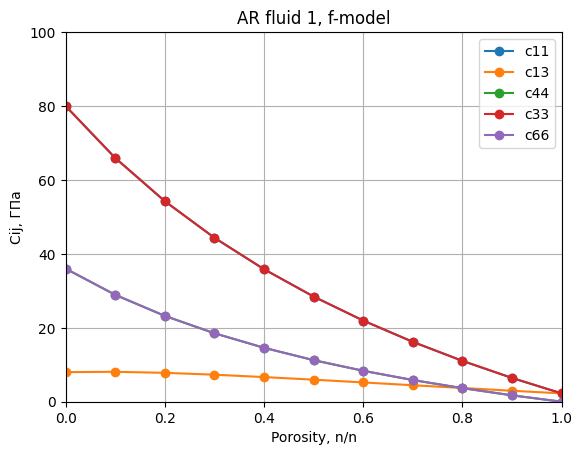

In [24]:
c11, c13, c44, c33, c66 = [], [], [], [], []
porosity = np.arange(0, 1.1, 0.1)

g_m = tensor_g(C_c, [1, 1, 1])
g_fl = g_m

for i in porosity:

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.plot(porosity, c33, label='c33', marker="o")
plt.plot(porosity, c66, label='c66', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 1, f-model')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

Porosity  0.0
[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]

Porosity  0.1
[[66.50586  8.0397   8.0397   0.       0.       0.     ]
 [ 8.0397  66.50586  8.0397   0.       0.       0.     ]
 [ 8.0397   8.0397  66.50586  0.       0.       0.     ]
 [ 0.       0.       0.      29.23308  0.       0.     ]
 [ 0.       0.       0.       0.      29.23308  0.     ]
 [ 0.       0.       0.       0.       0.      29.23308]]

Porosity  0.2
[[55.09189  7.74943  7.74943  0.       0.       0.     ]
 [ 7.74943 55.09189  7.74943  0.       0.       0.     ]
 [ 7.74943  7.74943 55.09189  0.       0.       0.     ]
 [ 0.       0.       0.      23.67123  0.       0.     ]
 [ 0.       0.       0.       0.      23.67123  0.     ]
 [ 0.       0.       0.       0.       0.      23.67123]]

Porosity  0.30000000000000004
[[45.29258  7.25485  7.25485  0.       0.       0.     ]
 [ 7.25485 45.29258

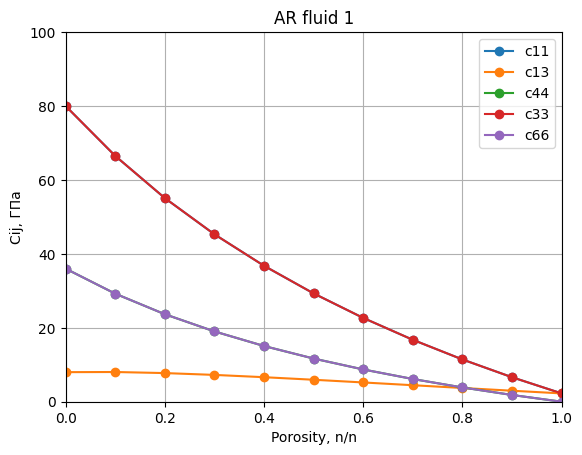

In [14]:
c11, c13, c44, c33, c66 = [], [], [], [], []
porosity = np.arange(0, 1.1, 0.1)

g_m = tensor_g(C_c, [1, 1, 1])
g_fl = g_m

for i in porosity:

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.plot(porosity, c33, label='c33', marker="o")
plt.plot(porosity, c66, label='c66', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 1')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

Aspect ratio 0.1 (VTI)

Porosity  0.0
[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]

Porosity  0.1
[[70.91836  7.3826   6.21346  0.       0.       0.     ]
 [ 7.3826  70.91836  6.21346  0.       0.       0.     ]
 [ 6.39096  6.39096 38.22243  0.       0.       0.     ]
 [ 0.       0.       0.      19.41218  0.       0.     ]
 [ 0.       0.       0.       0.      19.41218  0.     ]
 [ 0.       0.       0.       0.       0.      31.76788]]

Porosity  0.2
[[62.18729  6.79182  5.3757   0.       0.       0.     ]
 [ 6.79182 62.18729  5.3757   0.       0.       0.     ]
 [ 5.58428  5.58428 23.80995  0.       0.       0.     ]
 [ 0.       0.       0.      12.31764  0.       0.     ]
 [ 0.       0.       0.       0.      12.31764  0.     ]
 [ 0.       0.       0.       0.       0.      27.69773]]

Porosity  0.30000000000000004
[[53.76964  6.20876  4.79245  0.       0.       0.     ]
 [ 6.20876 53.76964

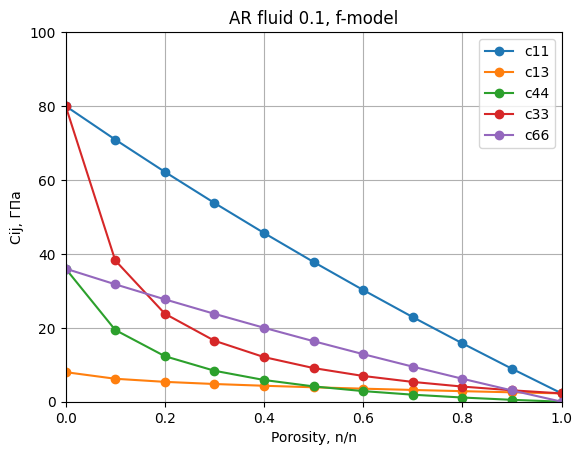

In [25]:
c11, c13, c44, c33, c66 = [], [], [], [], []
porosity = np.arange(0, 1.1, 0.1)

g_m = tensor_g(C_c, [1, 1, 1])
g_fl = tensor_g(C_c, [10, 10, 1])

for i in porosity:

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.plot(porosity, c33, label='c33', marker="o")
plt.plot(porosity, c66, label='c66', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 0.1, f-model')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

Porosity  0.0
[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]

Porosity  0.1
[[71.30535  7.3597   6.21385  0.       0.       0.     ]
 [ 7.3597  71.30535  6.21385  0.       0.       0.     ]
 [ 6.21385  6.21385 38.71488  0.       0.       0.     ]
 [ 0.       0.       0.      19.90183  0.       0.     ]
 [ 0.       0.       0.       0.      19.90183  0.     ]
 [ 0.       0.       0.       0.       0.      31.97283]]

Porosity  0.2
[[62.85838  6.75746  5.37718  0.       0.       0.     ]
 [ 6.75746 62.85838  5.37718  0.       0.       0.     ]
 [ 5.37718  5.37718 24.20196  0.       0.       0.     ]
 [ 0.       0.       0.      12.76606  0.       0.     ]
 [ 0.       0.       0.       0.      12.76606  0.     ]
 [ 0.       0.       0.       0.       0.      28.05046]]

Porosity  0.30000000000000004
[[54.62686  6.16912  4.79784  0.       0.       0.     ]
 [ 6.16912 54.62686

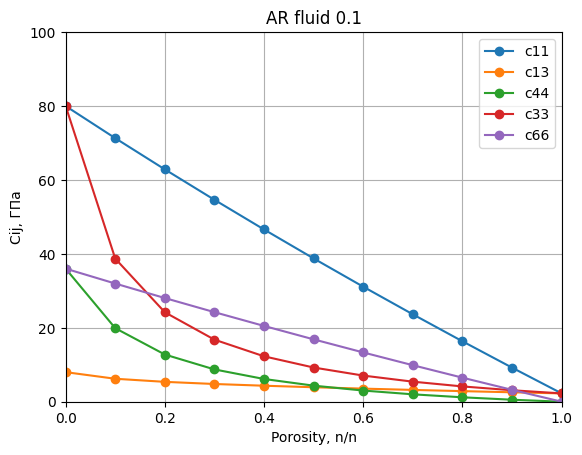

In [15]:
c11, c13, c44, c33, c66 = [], [], [], [], []
porosity = np.arange(0, 1.1, 0.1)

g_m = tensor_g(C_c, [1, 1, 1])
g_fl = tensor_g(C_c, [10, 10, 1])

for i in porosity:

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.plot(porosity, c33, label='c33', marker="o")
plt.plot(porosity, c66, label='c66', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 0.1')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

Aspect ratio 0.01 (VTI)

Porosity  0.0
[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]

Porosity  0.1
[[71.8828   7.17036  3.84476  0.       0.       0.     ]
 [ 7.17036 71.8828   3.84476  0.       0.       0.     ]
 [ 3.84476  3.84476 20.99185  0.       0.       0.     ]
 [ 0.       0.       0.       4.57556  0.       0.     ]
 [ 0.       0.       0.       0.       4.57556  0.     ]
 [ 0.       0.       0.       0.       0.      32.35622]]

Porosity  0.2
[[64.02983  6.58529  3.17525  0.       0.       0.     ]
 [ 6.58529 64.02983  3.17525  0.       0.       0.     ]
 [ 3.17525  3.17525 11.86839  0.       0.       0.     ]
 [ 0.       0.       0.       2.18808  0.       0.     ]
 [ 0.       0.       0.       0.       2.18808  0.     ]
 [ 0.       0.       0.       0.       0.      28.72227]]

Porosity  0.30000000000000004
[[56.22392  6.02769  2.88462  0.       0.       0.     ]
 [ 6.02769 56.22392

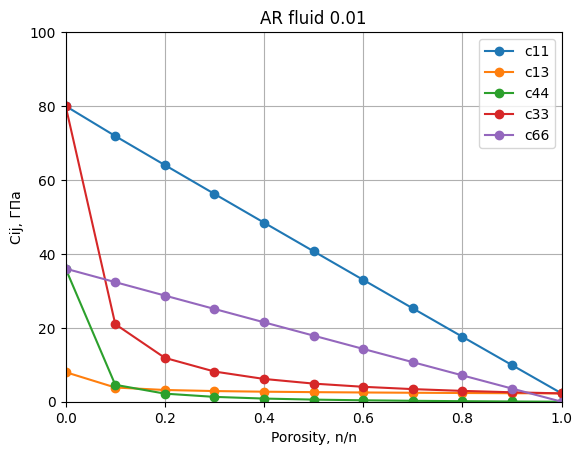

In [21]:
c11, c13, c44, c33, c66 = [], [], [], [], []
# porosity = np.arange(0.0, 1.1, 0.1)
porosity = np.arange(0, 1.1, 0.1)

g_m = tensor_g(C_c, [1, 1, 1])
g_fl = tensor_g(C_c, [100, 100, 1])


for i in porosity:

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.plot(porosity, c33, label='c33', marker="o")
plt.plot(porosity, c66, label='c66', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 0.01')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

In [31]:
c11, c13, c44, c33, c66 = [], [], [], [], []

C_c = C_mtrx

porosity = 0.1

AR = [1, 10, 100, 1000]

g_m = tensor_g(C_c, [1, 1, 1])

for i in AR:

  g_fl = tensor_g(C_c, [i, i, 1])

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

Porosity  0.1
[[66.50586  8.0397   8.0397   0.       0.       0.     ]
 [ 8.0397  66.50586  8.0397   0.       0.       0.     ]
 [ 8.0397   8.0397  66.50586  0.       0.       0.     ]
 [ 0.       0.       0.      29.23308  0.       0.     ]
 [ 0.       0.       0.       0.      29.23308  0.     ]
 [ 0.       0.       0.       0.       0.      29.23308]]

Porosity  0.1
[[71.30535  7.3597   6.21385  0.       0.       0.     ]
 [ 7.3597  71.30535  6.21385  0.       0.       0.     ]
 [ 6.21385  6.21385 38.71488  0.       0.       0.     ]
 [ 0.       0.       0.      19.90183  0.       0.     ]
 [ 0.       0.       0.       0.      19.90183  0.     ]
 [ 0.       0.       0.       0.       0.      31.97283]]

Porosity  0.1
[[71.8828   7.17036  3.84476  0.       0.       0.     ]
 [ 7.17036 71.8828   3.84476  0.       0.       0.     ]
 [ 3.84476  3.84476 20.99185  0.       0.       0.     ]
 [ 0.       0.       0.       4.57556  0.       0.     ]
 [ 0.       0.       0.       0.       4.5

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Porosity  0.1
[[71.92394  7.13272  3.45716  0.       0.       0.     ]
 [ 7.13272 71.92394  3.45716  0.       0.       0.     ]
 [ 3.45716  3.45716 18.27344  0.       0.       0.     ]
 [ 0.       0.       0.       0.52556  0.       0.     ]
 [ 0.       0.       0.       0.       0.52556  0.     ]
 [ 0.       0.       0.       0.       0.      32.39561]]



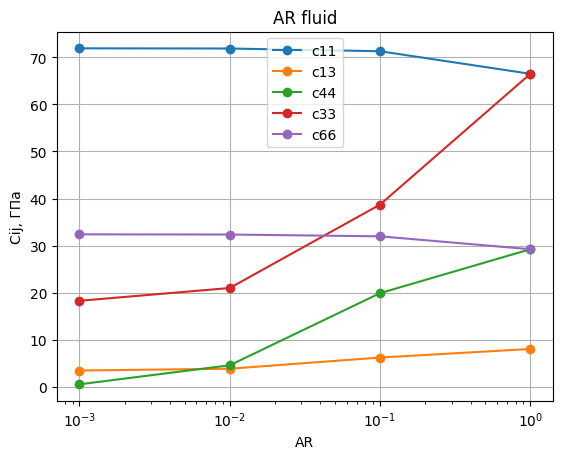

In [33]:
AR = [1, 0.1, 0.01, 0.001]

plt.plot(AR, c11, label='c11', marker="o")
plt.plot(AR, c13, label='c13', marker="o")
plt.plot(AR, c44, label='c44', marker="o")
plt.plot(AR, c33, label='c33', marker="o")
plt.plot(AR, c66, label='c66', marker="o")

plt.xscale("log")
plt.xlabel('AR')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid')

plt.grid()
plt.legend()


# BackUp

In [ ]:
def integration(C_c, ar):

  A_klnm = np.empty((3,3,3,3))

  for i in range(3):
      for j in range(3):
          for k in range(3):
              for l in range(3):

                # if i==j==k==l==0 or i==j==k==l==1 or i==j==k==l==2 or (i==j==0 and k==l==1) or (i==j==0 and k==l==2) or \
                #   (i==j==1 and k==l==0) or (i==j==2 and k==l==0) or \
                #   (i==j==2 and k==l==0) or (i==j==2 and k==l==1)or\
                #   (i==j==1 and k==l==2) or \
                #   (i==1 and j==2 and k==1 and l==2) or (i==2 and j==1 and k==2 and l==1) or\
                #   (i==1 and j==2 and k==2 and l==1) or (i==2 and j==1 and k==1 and l==2) or\
                #   (i==0 and j==2 and k==0 and l==2) or (i==2 and j==0 and k==2 and l==0) or\
                #   (i==2 and j==0 and  k==0 and l==2) or (i==0 and j==2 and k==2 and l==0) or\
                #   (i==0 and j==1 and k==0 and l==1) or (i==1 and j==0 and k==1 and l==0) or\
                #   (i==1 and j==0 and k==0 and l==1) or (i==0 and j==1 and k==1 and l==0):

                  A_klnm[i,j,k,l], _ = integrate.dblquad(lambda θ, φ: Function(C_c, θ, φ, ar)[i,j,k,l]*np.sin(θ), 0, 2*np.pi, \
                                                      lambda θ: 0, lambda θ: np.pi, epsabs=1.49e-8, epsrel=1.49e-8)
                  # print(i+1, j+1, k+1, l+1,  A_klnm[i,j,k,l]*(-1 /(4*np.pi)))
                # else:
                #   A_klnm[i,j,k,l] = 10***-18



  A_klnm = -1/(4*np.pi)*A_klnm

  g = np.empty((3,3,3,3))

  for i in range(3):
      for j in range(3):
          for k in range(3):
              for l in range(3):
                g[i,j,k,l] = (A_klnm[i,k,l,j]+A_klnm[i,l,k,j]+A_klnm[j,k,l,i]+A_klnm[j,l,k,i])*0.25

  return g

In [ ]:
import numpy as np
import scipy.integrate as integrate


def tensor_g_try(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])

        n = n_vector.T @ n_vector
        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ)*np.sin(θ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-10
    relerr = 1.0e-10
    points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr,
        'points': points
        }

    cc_list = []

    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):

                  if (i==0 and j==0 and k==0 and l==0) or (i==0 and j==0 and k==1 and l==1) or (i==1 and j==2 and k==1 and l==2):

                    integrand = lambda θ, φ: func(θ, φ, (i,j,k,l))
                    integral,_ = integrate.nquad(integrand, [(0, np.pi), (0, 2*np.pi)],
                                                  opts=opts)

                    cc_list.append(integral*(-1/(4*np.pi)))


    return cc_list[0], cc_list[1], cc_list[2]

In [ ]:
def integration(C_c, ar):

  A_klnm = np.zeros((3,3,3,3))

  for i in range(3):
      for j in range(3):
          for k in range(3):
              for l in range(3):


                  A_klnm[i,j,k,l], _ = integrate.dblquad(lambda θ, φ: Function(C_c, θ, φ, ar)[i,j,k,l]*np.sin(θ), 0, 2*np.pi, \
                                                      lambda θ: 0, lambda θ: np.pi, epsabs=1.49e-8, epsrel=1.49e-8)
  A_klnm = (-1/(4*np.pi))*A_klnm

  g = np.zeros((3,3,3,3))

  for i in range(3):
      for j in range(3):
          for k in range(3):
              for l in range(3):
                g[i,j,k,l] = (A_klnm[i,k,l,j]+A_klnm[i,l,k,j]+A_klnm[j,k,l,i]+A_klnm[j,l,k,i])*0.25
  return g